# **DEEP LEARNING PROJECT**
**IMAGE CAPTIONING (EFFICIENTNET + TRANSFORMER)**

KELOMPOK 9:
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Renaldo - 2702235670

DATASET: Flickr8k Dataset for image captioning.

LINK KAGGLE : https://www.kaggle.com/datasets/adityajn105/flickr8k



# **IMPORT LIBRARIES & SETUP**

In [ ]:
!pip install nltk rouge-score
!pip install git+https://github.com/salaniz/pycocoevalcap

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=dd9f54cf815d8be0113f73e5ef8d86ca0bcc0a8f614677399fa5bb428633cddc
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-cqx_wl7p
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-cqx_wl7p
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=3ee7ea765a54a3c89a3036c3ea25d77cdbce0f07d06d1ab565793cfd6ce35ce6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7x7pe3k1/wheels/03/ce/0b/3d3fdeecb09b4f4ebcfb3ff28d27a9f5b3c1a7b73897ad122d
Successfully built 

In [ ]:
import os
import re
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import nltk
import kagglehub

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
path = kagglehub.dataset_download("adityajn105/flickr8k")
print(path)
print(os.listdir(path))

Using Colab cache for faster access to the 'flickr8k' dataset.
/kaggle/input/flickr8k
['captions.txt', 'Images']


In [ ]:
# ======================================================
# PATH DATASET KAGGLE FLICKR8K (adityajn105/flickr8k)
# ======================================================

path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Dataset path:", path)

# detect caption file automatically
possible_files = ["captions.txt", "Flickr8k.token.txt"]

CAPTION_FILE = None
for f in possible_files:
    candidate = os.path.join(path, f)
    if os.path.exists(candidate):
        CAPTION_FILE = candidate
        break

IMAGES_DIR = os.path.join(path, "Images")

print("Images dir exists :", os.path.exists(IMAGES_DIR))
print("Captions file :", CAPTION_FILE)
print("Exists:", os.path.exists(CAPTION_FILE))


Using Colab cache for faster access to the 'flickr8k' dataset.
Dataset path: /kaggle/input/flickr8k
Images dir exists : True
Captions file : /kaggle/input/flickr8k/captions.txt
Exists: True


In [ ]:
# ======================================================
# LOAD & CLEAN CAPTIONS
# ======================================================

def load_captions(filepath):
    caps = defaultdict(list)
    with open(filepath, "r") as f:
        first = True
        for line in f:
            line = line.strip()
            if not line:
                continue
            # skip header
            if first and line.lower().startswith("image"):
                first = False
                continue
            first = False

            img_id, caption = line.split(",", 1)
            img_id = img_id.split("#")[0].strip()
            caps[img_id].append(caption.strip())
    return caps

raw_captions = load_captions(CAPTION_FILE)
print("Jumlah image dengan caption:", len(raw_captions))
sample_id = list(raw_captions.keys())[0]
print("Contoh raw:", sample_id, "->", raw_captions[sample_id][:3])

Jumlah image dengan caption: 8091
Contoh raw: 1000268201_693b08cb0e.jpg -> ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .']


# **PREPROCESSING**

In [ ]:
# ======================================================
# CLEAN TEKS + TAMBAH startseq / endseq
# ======================================================

def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-z ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

clean_captions = defaultdict(list)

for img, caps in raw_captions.items():
    for c in caps:
        c = clean_caption(c)
        if len(c.split()) < 3:
            continue
        clean_captions[img].append(f"startseq {c} endseq")

print("Contoh clean:")
print(sample_id, "->", clean_captions[sample_id][:3])

Contoh clean:
1000268201_693b08cb0e.jpg -> ['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq a girl going into a wooden building endseq', 'startseq a little girl climbing into a wooden playhouse endseq']


In [ ]:
# ======================================================
# TRAIN / VAL / TEST SPLIT
# ======================================================

image_ids = sorted(clean_captions.keys())

train_ids, temp_ids = train_test_split(image_ids, test_size=0.2, random_state=SEED)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

print("Train:", len(train_ids))
print("Val:", len(val_ids))
print("Test:", len(test_ids))

Train: 6472
Val: 809
Test: 810


In [ ]:
# ======================================================
# TOKENIZER & MAX LENGTH CAPTION
# ======================================================

train_caps_list = []
for img in train_ids:
    train_caps_list.extend(clean_captions[img])

VOCAB_SIZE = 15000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(train_caps_list)

vocab_size = tokenizer.num_words
word_index = tokenizer.word_index
index_word = {v:k for k,v in word_index.items()}

start_id = word_index["startseq"]
end_id   = word_index["endseq"]
unk_id   = word_index["<unk>"]

max_len = max(len(c.split()) for c in train_caps_list)
print("Vocab:", vocab_size, "Max len:", max_len)

# (opsional) simpan tokenizer supaya evaluasi di run lain tetap konsisten
import pickle
with open("tokenizer_flickr8k_efficientnet_transformer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

Vocab: 15000 Max len: 38


In [ ]:
# ======================================================
# AUGMENTATION & LOAD IMAGE
# ======================================================

augment_layer = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomContrast(0.1),
])

def load_image(path):
    img = load_img(path, target_size=(224, 224))
    arr = img_to_array(img) / 255.0
    return arr

In [ ]:
# ======================================================
# PRE-FILTER VALID IDs
# ======================================================

def filter_valid_ids(ids, captions):
    """Filter hanya IDs yang valid"""
    valid_ids = []
    invalid_count = 0

    for img_id in ids:
        img_path = safe_image_path(img_id)
        if os.path.exists(img_path) and img_id in captions:
            valid_ids.append(img_id)
        else:
            invalid_count += 1

    print(f"Filtered: {len(valid_ids)} valid, {invalid_count} invalid")
    return valid_ids

# **CORE COMPONENTS SETUP**

In [ ]:
# ======================================================
# GENERATOR
# ======================================================

IMG_SIZE = (224, 224)

def safe_image_path(img_id):
    base = os.path.splitext(img_id)[0]
    return os.path.join(IMAGES_DIR, base + ".jpg")

def data_generator(ids, captions, tokenizer, batch_size, training=True):
    global vocab_size

    # Pre-filter valid IDs
    valid_ids = []
    for img_id in ids:
        img_path = safe_image_path(img_id)
        if os.path.exists(img_path) and img_id in captions:
            valid_ids.append(img_id)

    if len(valid_ids) == 0:
        raise ValueError("Tidak ada gambar valid untuk generator!")

    print(f"Generator initialized: {len(valid_ids)}/{len(ids)} valid images")

    while True:
        random.shuffle(valid_ids)

        X_img, X_seq, y = [], [], []

        for img_id in valid_ids:
            img_path = safe_image_path(img_id)

            # Load image
            try:
                img = load_img(img_path, target_size=IMG_SIZE)
                img = img_to_array(img)

                if training:
                    # Random horizontal flip
                    if np.random.rand() > 0.5:
                        img = np.fliplr(img)
                    # Random brightness
                    if np.random.rand() > 0.5:
                        factor = np.random.uniform(0.9, 1.1)
                        img = np.clip(img * factor, 0, 255)

                    # using augment layer
                    # img = augment_layer(tf.expand_dims(img, 0))[0].numpy()

                img = preprocess_input(img)

            except Exception as e:
                continue

            # Load caption
            cap = random.choice(captions[img_id])
            seq = tokenizer.texts_to_sequences([cap])[0]

            if len(seq) < 2:
                continue

            # Generate input-output sequence
            pos = random.randint(1, len(seq) - 1)
            in_seq = seq[:pos]
            out_seq = seq[pos]

            # Padding
            in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post', truncating='post')[0]

            # Add to batch
            X_img.append(img)
            X_seq.append(in_seq)
            y.append(out_seq)

            # Yield when batch is full
            if len(X_img) == batch_size:
                # Convert Y to one-hot
                y_one_hot = np.zeros((batch_size, vocab_size), dtype=np.float32)
                for i, token_id in enumerate(y):
                    if 0 <= token_id < vocab_size:
                        y_one_hot[i, token_id] = 1.0

                yield (
                    {
                        "image_input": np.array(X_img, dtype=np.float32),
                        "caption_input": np.array(X_seq, dtype=np.int32)
                    },
                    y_one_hot
                )

                # Reset batch
                X_img, X_seq, y = [], [], []

In [ ]:
# ======================================================
# POSITIONAL EMBEDDING
# ======================================================

class PositionalEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, d_model, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.d_model = d_model

        self.token_emb = layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_emb = layers.Embedding(max_len, d_model)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(0, seq_len)
        pos = self.pos_emb(positions)
        tok = self.token_emb(x)
        return tok + pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_len": self.max_len,
            "vocab_size": self.vocab_size,
            "d_model": self.d_model
        })
        return config

In [ ]:
# ======================================================
# TRANSFORMER DECODER LAYER - FIXED
# ======================================================

class TransformerDecoderLayer(layers.Layer):
    def __init__(self, d_model, heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.heads = heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        # Multi-head attention
        self.self_att = layers.MultiHeadAttention(
            num_heads=heads,
            key_dim=d_model // heads
        )
        self.cross_att = layers.MultiHeadAttention(
            num_heads=heads,
            key_dim=d_model // heads
        )

        # Feed-forward
        self.ff = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model)
        ])

        # Normalization
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.norm3 = layers.LayerNormalization()

        # Dropout
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)
        self.drop3 = layers.Dropout(dropout)

    def call(self, x, enc, training=False):
        # 1. Masked self-attention (causal)
        attn1 = self.self_att(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True,
            training=training
        )
        x = self.norm1(x + self.drop1(attn1, training=training))

        # 2. Cross-attention dengan image features
        attn2 = self.cross_att(
            query=x,
            value=enc,
            key=enc,
            training=training
        )
        x = self.norm2(x + self.drop2(attn2, training=training))

        # 3. Feed-forward
        ff = self.ff(x)
        x = self.norm3(x + self.drop3(ff, training=training))

        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "heads": self.heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout_rate
        })
        return config

# **MODEL BUILDING**

In [ ]:
# ======================================================
# BUILD MODEL - COMPLETE VERSION
# ======================================================
d_model = 256
num_heads = 4
ff_dim = 512
num_layers = 2

# IMAGE INPUT
img_input = keras.Input(shape=(224, 224, 3), name="image_input")
base_cnn = EfficientNetB0(include_top=False, weights="imagenet")
base_cnn.trainable = False

# Extract dan transform features
feat = base_cnn(img_input)
feat = layers.Conv2D(d_model, 1, name="feat_projection")(feat)
feat = layers.Reshape((-1, d_model), name="feat_flatten")(feat)
enc = layers.LayerNormalization(name="feat_norm")(feat)
enc = layers.Dropout(0.25, name="feat_drop")(enc)

# CAPTION INPUT
seq_input = keras.Input(shape=(max_len,), name="caption_input")
x = PositionalEmbedding(max_len, vocab_size, d_model, name="pos_embed")(seq_input)
x = layers.Dropout(0.2, name="embed_drop")(x)

# TRANSFORMER DECODER LAYERS
for i in range(num_layers):
    x = TransformerDecoderLayer(
        d_model=d_model,
        heads=num_heads,
        ff_dim=ff_dim,
        dropout=0.2,
        name=f"decoder_layer_{i}"
    )(x, enc)

# Output
x = layers.Lambda(lambda t: t[:, -1, :], name="last_token")(x)
logits = layers.Dense(vocab_size, name="output_logits")(x)

# Build model
model = keras.Model(
    inputs=[img_input, seq_input],
    outputs=logits,
    name="image_captioning"
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "image_captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_projection     │ (None, 7, 7, 256) │    327,936 │ efficientnetb0[0… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_flatten        │ (None, 49, 256)   │          0 │ feat_projection[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_embed           │ (None, 38, 256)   │  3,849,728 │ caption_input[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_norm           │ (None, 49, 256)   │        512 │ feat_flatten[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_drop          │ (None, 38, 256)   │          0 │ pos_embed[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_drop (Dropout) │ (None, 49, 256)   │          0 │ feat_norm[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_0     │ (None, 38, 256)   │    790,784 │ embed_drop[0][0], │
│ (TransformerDecode… │                   │            │ feat_drop[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_1     │ (None, 38, 256)   │    790,784 │ decoder_layer_0[… │
│ (TransformerDecode… │                   │            │ feat_drop[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_token (Lambda) │ (None, 256)       │          0 │ decoder_layer_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_logits       │ (None, 15000)     │  3,855,000 │ last_token[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,664,315 (52.13 MB)

 Trainable params: 9,614,744 (36.68 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
batch = 64

print("\n=== Filtering Valid IDs ===")
train_ids_valid = filter_valid_ids(train_ids, clean_captions)
val_ids_valid = filter_valid_ids(val_ids, clean_captions)
test_ids_valid = filter_valid_ids(test_ids, clean_captions)

batch = 64
steps_train = len(train_ids_valid) // batch
steps_val = len(val_ids_valid) // batch

print(f"\n=== Steps Calculation ===")
print(f"Train: {len(train_ids_valid)} samples → {steps_train} steps")
print(f"Val: {len(val_ids_valid)} samples → {steps_val} steps")

train_gen = data_generator(train_ids_valid, clean_captions, tokenizer, batch, training=True)
val_gen = data_generator(val_ids_valid, clean_captions, tokenizer, batch, training=False)


=== Filtering Valid IDs ===
Filtered: 6472 valid, 0 invalid
Filtered: 809 valid, 0 invalid
Filtered: 810 valid, 0 invalid

=== Steps Calculation ===
Train: 6472 samples → 101 steps
Val: 809 samples → 12 steps


In [ ]:
for img_id in train_ids[:20]:
    img_path = os.path.join(IMAGES_DIR, img_id)
    print(img_id, os.path.exists(img_path), clean_captions[img_id])

3393152604_27bd1037f2.jpg True ['startseq a bulldog jumps over a log next to a stream endseq', 'startseq a dog is pawing at a fallen log nearby a stream in an area with pinestraw endseq', 'startseq black and white dog grabs tree limb endseq', 'startseq the black and white dog jumps by a log near a creek endseq', 'startseq the dog plays with the large log endseq']
3549673305_4dfd44e04a.jpg True ['startseq a couple kissing on the neck on a busy street endseq', 'startseq a man embraces a woman on a crowded street endseq', 'startseq a man in a leather jacket with the collar popped kisses the neck of a woman in a gray coat wearing a white scarf endseq', 'startseq man kisses girl on neck endseq', 'startseq man kissing a woman s neck on a busy sidewalk endseq']
3181328245_7c04ce1691.jpg True ['startseq two babies are sitting in a play mat endseq', 'startseq two babies playing inside of a colorful padded enclosure endseq', 'startseq two children sit inside a play area endseq', 'startseq two to

In [ ]:
b = next(train_gen)
print("DEBUG BATCH")
print("IMG:", b[0]["image_input"].shape)
print("SEQ:", b[0]["caption_input"].shape)
print("Y  :", b[1].shape)

Generator initialized: 6472/6472 valid images
DEBUG BATCH
IMG: (64, 224, 224, 3)
SEQ: (64, 38)
Y  : (64, 15000)


# **TRAINING**

In [ ]:
# ======================================================
# TRAINING PHASE 1
# ======================================================

from tensorflow.keras.metrics import CategoricalAccuracy

model.compile(
    optimizer = keras.optimizers.AdamW(
        learning_rate=2e-4,
        weight_decay=1e-4
    ),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[CategoricalAccuracy()] # Gunakan CategoricalAccuracy instead of accuracy
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_caption_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("\n=== Phase 1: Training with Frozen CNN ===")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


=== Phase 1: Training with Frozen CNN ===
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - categorical_accuracy: 0.0966 - loss: 8.2652Generator initialized: 809/809 valid images

Epoch 1: val_loss improved from inf to 5.61772, saving model to best_caption_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 117s 656ms/step - categorical_accuracy: 0.0968 - loss: 8.2540 - val_categorical_accuracy: 0.1510 - val_loss: 5.6177 - learning_rate: 2.0000e-04
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - categorical_accuracy: 0.1506 - loss: 5.5019
Epoch 2: val_loss improved from 5.61772 to 5.32759, saving model to best_caption_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - categorical_accuracy: 0.1508 - loss: 5.5011 - val_categorical_accuracy: 0.1901 - val_loss: 5.3276 - learning_rate: 2.0000e-04
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - categorical_accuracy: 0.1891 - loss: 5.3305
Epoch 3: val_loss improved from 5.32759 to 5.00542, saving model to best_caption_model

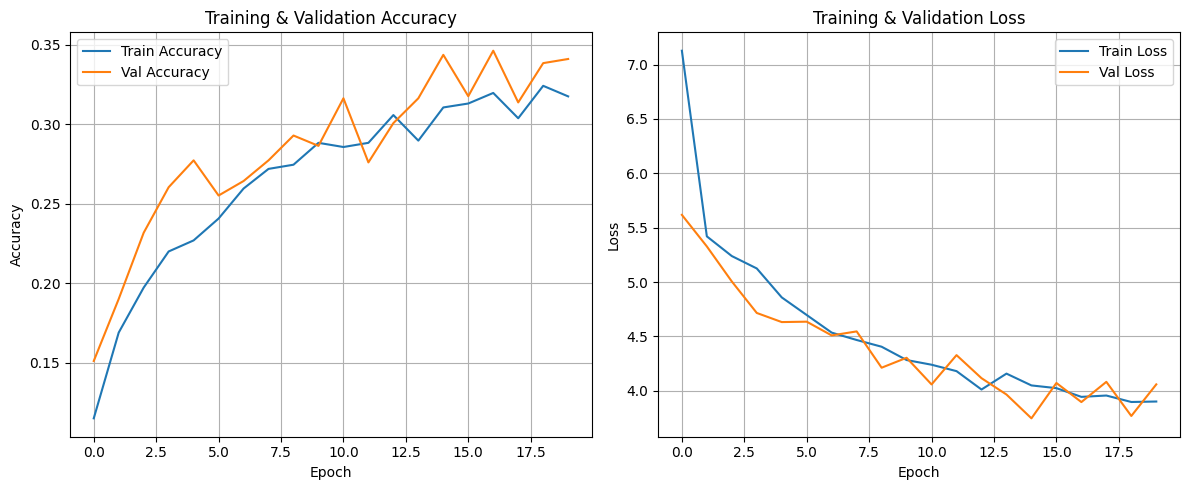

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ======================================================
# FINE-TUNING - PHASE 2 (Unfreeze Top Layers)
# ======================================================
print("\n=== Phase 2: Fine-tuning Top Layers ===")

# Re-create generators untuk reset state
train_gen = data_generator(train_ids_valid, clean_captions, tokenizer, batch, training=True)
val_gen = data_generator(val_ids_valid, clean_captions, tokenizer, batch, training=False)

# Unfreeze top 25 layers
for layer in base_cnn.layers[-25:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-5,
        weight_decay=1e-5
    ),
    loss=keras.losses.CategoricalCrossentropy(
        from_logits=True,
        label_smoothing=0.1
    ),
    metrics=[CategoricalAccuracy()]
)

history_ft = model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

# ======================================================
# SAVE FINAL MODEL
# ======================================================
model.save("final_caption_model_ft.keras")
print("\nTraining selesai! Model tersimpan.")


=== Phase 2: Fine-tuning Top Layers ===
Generator initialized: 6472/6472 valid images
Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - categorical_accuracy: 0.3033 - loss: 4.9106Generator initialized: 809/809 valid images

Epoch 1: val_loss did not improve from 3.74697
101/101 ━━━━━━━━━━━━━━━━━━━━ 93s 440ms/step - categorical_accuracy: 0.3033 - loss: 4.9104 - val_categorical_accuracy: 0.3229 - val_loss: 4.9243 - learning_rate: 1.0000e-05
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - categorical_accuracy: 0.3134 - loss: 4.7779
Epoch 2: val_loss did not improve from 3.74697
101/101 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - categorical_accuracy: 0.3134 - loss: 4.7779 - val_categorical_accuracy: 0.3125 - val_loss: 4.7673 - learning_rate: 1.0000e-05
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - categorical_accuracy: 0.3027 - loss: 4.8075
Epoch 3: val_loss did not improve from 3.74697
101/101 ━━━━━━━━━━━━━━━━━━━━ 34s 341ms/step - categorical_accuracy: 0.3027 - loss: 4

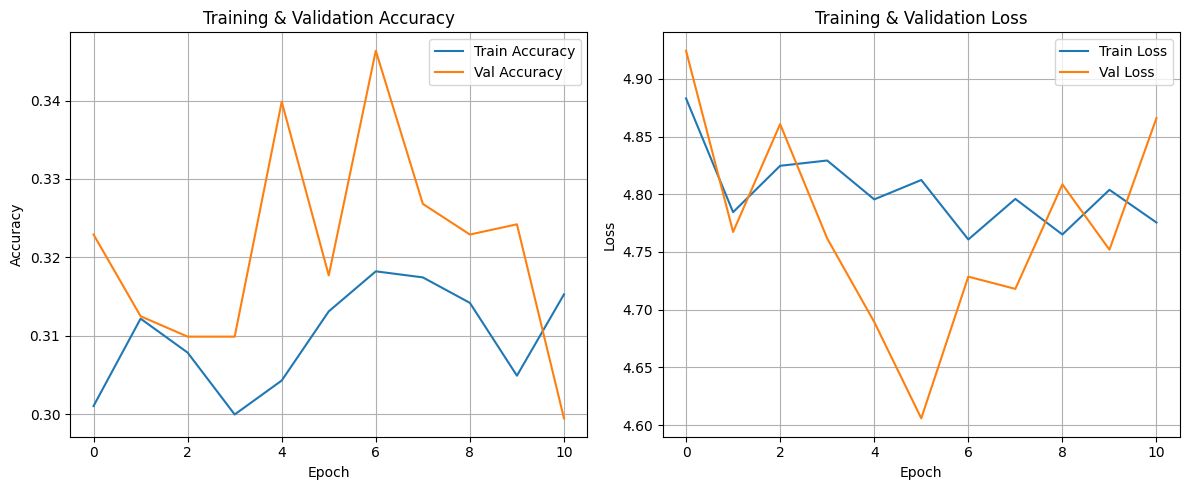

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_ft.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# **INFERENCE FUNCTIONS**

In [ ]:
# ======================================================
# HELPER: PREPROCESS IMAGE
# ======================================================
def _load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img)
    arr = preprocess_input(arr)
    arr = np.expand_dims(arr, 0)
    return arr

In [ ]:
# ======================================================
# 1. GREEDY DECODING (STABLE + AUTO-BIAS + NO-REPEAT-BIGRAM)
# ======================================================

def greedy_caption(model, img_path, tokenizer, max_len):

    start_id = tokenizer.word_index.get('<start>', tokenizer.word_index.get('startseq', 1))
    end_id   = tokenizer.word_index.get('<end>',   tokenizer.word_index.get('endseq', 2))
    unk_id   = tokenizer.word_index.get('<unk>',   0)
    index_word = {v: k for k, v in tokenizer.word_index.items()}

    arr = _load_and_preprocess_image(img_path, target_size=(224, 224))

    seq = [start_id]
    words = []
    used_bigrams = set()

    for step in range(max_len):

        seq_pad = pad_sequences([seq], maxlen=max_len, padding='post')
        logits = model.predict([arr, seq_pad], verbose=0)[0]

        # Softmax stabil
        logits_shift = logits - np.max(logits)
        probs = np.exp(logits_shift)
        probs = probs / (np.sum(probs) + 1e-10)

        # 1. Penalize UNK
        if unk_id < len(probs):
            probs[unk_id] *= 0.001

        # 2. Immediate repetition penalty (token yang baru dipakai)
        if len(seq) >= 1:
            last_tok = seq[-1]
            if last_tok < len(probs):
                probs[last_tok] *= 0.01

        # 3. No-repeat bigram (hindari looping "dog is dog is")
        if len(seq) >= 1:
            for wid in range(len(probs)):
                if (seq[-1], wid) in used_bigrams:
                    probs[wid] *= 0.01  # ditekan keras

        # 4. AUTO-BIAS SUPPRESSION untuk 1–2 token awal
        if step < 2:
            top1 = np.argmax(probs)
            top1_prob = probs[top1]
            mean_prob = np.mean(probs)
            ratio = top1_prob / (mean_prob + 1e-9)

            # Jika satu token terlalu dominan (bias dataset), tekan
            if ratio > 12.0:
                probs[top1] *= 0.1

        # Renormalisasi
        probs = probs / (np.sum(probs) + 1e-10)

        wid = np.argmax(probs)

        if wid == end_id:
            break

        seq.append(wid)

        # Update bigram set
        if len(seq) >= 2:
            used_bigrams.add((seq[-2], seq[-1]))

        w = index_word.get(wid, "")
        if w not in ["<start>", "<end>", "<unk>", "startseq", "endseq", ""]:
            words.append(w)

    return " ".join(words)

In [ ]:
# ======================================================
# 2. BEAM SEARCH (LENGTH PENALTY + NO-REPEAT-BIGRAM + REP-PENALTY)
# ======================================================

def beam_search_caption(model, img_path, tokenizer, max_len,
                        beam_size=5, length_penalty=0.6,
                        rep_penalty=0.7):

    start_id = tokenizer.word_index.get('<start>', tokenizer.word_index.get('startseq', 1))
    end_id   = tokenizer.word_index.get('<end>',   tokenizer.word_index.get('endseq', 2))
    unk_id   = tokenizer.word_index.get('<unk>',   0)
    index_word = {v: k for k, v in tokenizer.word_index.items()}

    arr = _load_and_preprocess_image(img_path, target_size=(224, 224))

    # Beam item: (seq, log_prob, finished, bigram_set)
    beams = [([start_id], 0.0, False, set())]

    for step in range(max_len):
        candidates = []

        for seq, score, finished, bigrams in beams:
            if finished:
                candidates.append((seq, score, True, bigrams))
                continue

            seq_pad = pad_sequences([seq], maxlen=max_len, padding='post')
            logits = model.predict([arr, seq_pad], verbose=0)[0]

            # Softmax → log_probs
            logits_shift = logits - np.max(logits)
            probs = np.exp(logits_shift)
            probs = probs / (np.sum(probs) + 1e-10)
            log_probs = np.log(probs + 1e-12)

            # 1. Repetition penalty ringan (token-level)
            token_counts = {}
            for t in seq[1:]:
                token_counts[t] = token_counts.get(t, 0) + 1
            for t, c in token_counts.items():
                if t < len(log_probs) and c > 1:
                    log_probs[t] -= rep_penalty * (c - 1)

            # 2. Penalize UNK
            if unk_id < len(log_probs):
                log_probs[unk_id] -= 5.0

            # 3. No-repeat bigram → blok kandidat yang bikin bigram terulang
            vocab_size = len(log_probs)
            top_k = min(beam_size * 2, vocab_size)
            # ambil kandidat terbesar
            top_indices = np.argpartition(log_probs, -top_k)[-top_k:]
            top_indices = top_indices[np.argsort(log_probs[top_indices])][::-1]

            for idx in top_indices:
                # Cek bigram repeat
                if len(seq) >= 1 and (seq[-1], idx) in bigrams:
                    # skip kalau bigram sudah pernah
                    continue

                new_seq = seq + [idx]
                new_score = score + log_probs[idx]
                new_finished = (idx == end_id)

                new_bigrams = set(bigrams)
                if len(new_seq) >= 2:
                    new_bigrams.add((new_seq[-2], new_seq[-1]))

                candidates.append((new_seq, new_score, new_finished, new_bigrams))

        if not candidates:
            break

        # Length normalization
        def score_with_length(item):
            seq, score, finished, _ = item
            length = max(1, len(seq))
            lp = ((5 + length) / 6) ** length_penalty
            return score / lp

        candidates.sort(key=score_with_length, reverse=True)
        beams = candidates[:beam_size]

        # Early stop: semua beam sudah selesai
        if all(fin for _, _, fin, _ in beams):
            break

    # pilih beam terbaik
    best_seq, best_score, _, _ = max(beams, key=lambda x: score_with_length(x))

    words = []
    for wid in best_seq:
        if wid in (start_id, end_id):
            continue
        w = index_word.get(wid, "")
        if w not in ["<start>", "<end>", "<unk>", "startseq", "endseq", ""]:
            words.append(w)

    return " ".join(words)

In [ ]:
# ======================================================
# 3. NUCLEUS SAMPLING (TOP-p + TEMP + NO-REPEAT-BIGRAM)
# ======================================================
def nucleus_sampling_caption(model, img_path, tokenizer, max_len,
                             p=0.9, temperature=0.8,
                             rep_alpha=0.8):

    start_id = tokenizer.word_index.get('<start>', tokenizer.word_index.get('startseq', 1))
    end_id   = tokenizer.word_index.get('<end>',   tokenizer.word_index.get('endseq', 2))
    unk_id   = tokenizer.word_index.get('<unk>',   0)
    index_word = {v: k for k, v in tokenizer.word_index.items()}

    arr = _load_and_preprocess_image(img_path, target_size=(224, 224))

    seq = [start_id]
    words = []
    bigrams = set()

    for step in range(max_len):
        seq_pad = pad_sequences([seq], maxlen=max_len, padding='post')
        logits = model.predict([arr, seq_pad], verbose=0)[0]

        # Temperature scaling sebelum softmax
        scaled_logits = logits / max(temperature, 1e-6)
        scaled_logits -= np.max(scaled_logits)
        probs = np.exp(scaled_logits)
        probs = probs / (np.sum(probs) + 1e-10)

        # 1. UNK penalty
        if unk_id < len(probs):
            probs[unk_id] *= 0.01

        # 2. Repetition penalty (lebih smooth)
        token_counts = {}
        for t in seq[1:]:
            token_counts[t] = token_counts.get(t, 0) + 1
        for t, c in token_counts.items():
            if t < len(probs) and c > 0:
                probs[t] /= (1.0 + rep_alpha * c)

        # 3. No-repeat bigram (jangan sampling bigram yang sudah pernah)
        if len(seq) >= 1:
            for wid in range(len(probs)):
                if (seq[-1], wid) in bigrams:
                    probs[wid] *= 0.05  # ditekan, tapi tidak diblok total

        # Normalisasi ulang
        probs = probs / (np.sum(probs) + 1e-10)

        # === NUCLEUS SAMPLING ===
        sorted_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_indices]
        cumsum = np.cumsum(sorted_probs)

        cutoff_idx = np.searchsorted(cumsum, p)
        cutoff_idx = int(min(max(0, cutoff_idx), len(cumsum) - 1))

        nucleus_indices = sorted_indices[:cutoff_idx + 1]
        nucleus_probs = sorted_probs[:cutoff_idx + 1]

        # Fallback kalau nucleus terlalu kecil
        if len(nucleus_indices) == 0:
            nucleus_indices = sorted_indices[:3]
            nucleus_probs = sorted_probs[:3]

        nucleus_probs = nucleus_probs / (np.sum(nucleus_probs) + 1e-10)

        wid = np.random.choice(nucleus_indices, p=nucleus_probs)

        if wid == end_id:
            break

        seq.append(wid)

        if len(seq) >= 2:
            bigrams.add((seq[-2], seq[-1]))

        w = index_word.get(wid, "")
        if w not in ["<start>", "<end>", "<unk>", "startseq", "endseq", ""]:
            words.append(w)

    return " ".join(words)

# **TEST SINGLE IMAGE**

In [ ]:
# ======================================================
# TEST SINGLE IMAGE
# ======================================================

def test_one_image(model, img_id, method="beam"):

    # Build image path
    img_path = safe_image_path(img_id)

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return

    # Generate caption
    if method == "beam":
        result = beam_search_caption(
            model=model,
            img_path=img_path,
            tokenizer=tokenizer,
            max_len=max_len,
            beam_size=5,
            length_penalty=0.6,
            rep_penalty=0.7
        )
    elif method == "greedy":
        result = greedy_caption(
            model=model,
            img_path=img_path,
            tokenizer=tokenizer,
            max_len=max_len
        )
    else:  # nucleus
        result = nucleus_sampling_caption(
            model=model,
            img_path=img_path,
            tokenizer=tokenizer,
            max_len=max_len,
            p=0.9,
            temperature=0.8,
            rep_alpha=0.8
        )


    # Display
    img = load_img(img_path, target_size=(224, 224))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Generated ({method}): {result}", fontsize=12, wrap=True)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print(f"Image ID: {img_id}")
    print(f"Method: {method.upper()}")
    print(f"Generated: {result}")

    if img_id in clean_captions:
        print(f"\n{'Ground Truth Captions:':}")
        for i, cap in enumerate(clean_captions[img_id][:5], 1):
            print(f"  {i}. {cap}")
    print(f"{'='*60}\n")


Testing Single Image:


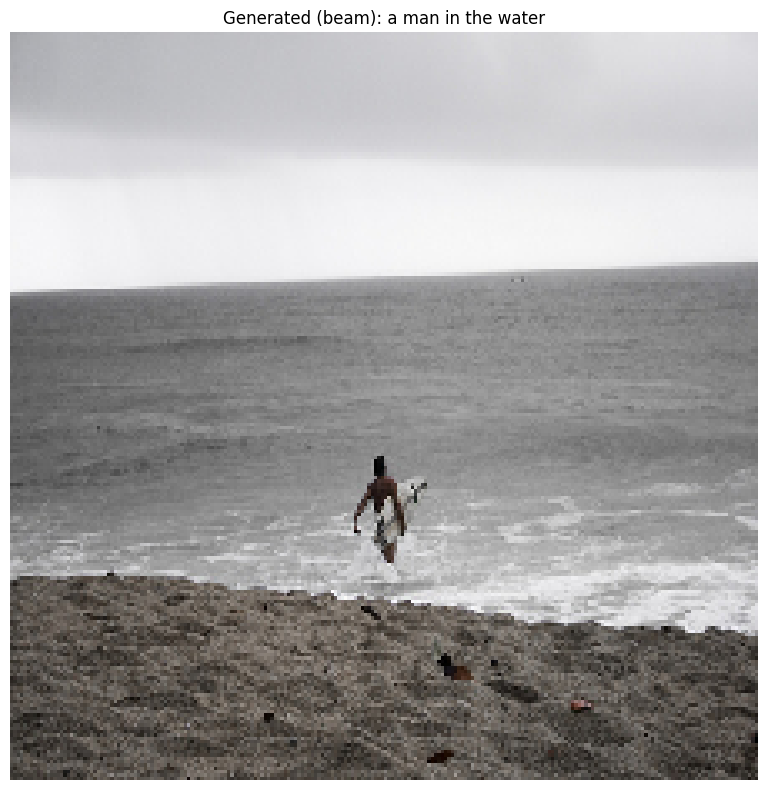


Image ID: 3532194771_07faf20d76.jpg
Method: BEAM
Generated: a man in the water

Ground Truth Captions:
  1. startseq a man is heading out to see with his surfboard in hand endseq
  2. startseq a man with a white surfboard is walking into the water endseq
  3. startseq a person walks into the water carrying a white surfboard endseq
  4. startseq a surfer walking into the ocean endseq
  5. startseq surfer with board marches out to sea on gray day endseq



In [ ]:
# Test single image
print("\nTesting Single Image:")
test_one_image(model, test_ids[1], method="beam")

# **COMPARISON 3 METHODS**

In [ ]:
# ======================================================
# COMPARISON FUNCTION - COMPLETE WITH ALL 6 METHODS
# ======================================================
def compare_all_methods(model, img_id, show_metrics=True):
    """
    Bandingkan SEMUA metode decoding (6 methods)
    """
    img_path = safe_image_path(img_id)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return

    print(f"\n{'='*80}")
    print(f"🖼️  Image ID: {img_id}")
    print(f"{'='*80}\n")

    results = {}

    # 1. Greedy
    print("⏳ Running Greedy...")
    results['greedy'] = greedy_caption(model, img_path, tokenizer, max_len)

    # 2. Beam search (Standard)
    print("⏳ Running Beam Search (Standard)...")
    results['beam_standard'] = beam_search_caption(
        model, img_path, tokenizer, max_len,
        beam_size=5, length_penalty=0.6,
        rep_penalty=0.7
    )

    # 3. Nucleus sampling
    print("⏳ Running Nucleus Sampling...")
    results['nucleus'] = nucleus_sampling_caption(
        model, img_path, tokenizer, max_len,
        p=0.9, temperature=0.8, rep_alpha=0.8
    )

    img = load_img(img_path, target_size=(224, 224))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    methods = [
        ('greedy',        'Greedy Decoding'),
        ('beam_standard', 'Beam Search'),
        ('nucleus',       'Nucleus Sampling')
    ]

    for idx, (key, title) in enumerate(methods):
        ax = axes[idx]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{title}\n{results[key]}", fontsize=11, wrap=True)

    plt.tight_layout()
    plt.show()

    # Print results table
    print(f"\n{'Method':<30s} | {'Generated Caption'}")
    print(f"{'-'*30} | {'-'*50}")
    for key, title in methods:
        print(f"{title:<30s} | {results[key]}")

    # Ground truth
    if img_id in clean_captions:
        print(f"\nGround Truth Captions:")
        for i, cap in enumerate(clean_captions[img_id][:3], 1):
            print(f"  {i}. {cap}")

    print(f"\n{'='*80}\n")

    return results


Comparing All Methods:

🖼️  Image ID: 3128514681_a51b415c31.jpg

⏳ Running Greedy...
⏳ Running Beam Search (Standard)...
⏳ Running Nucleus Sampling...


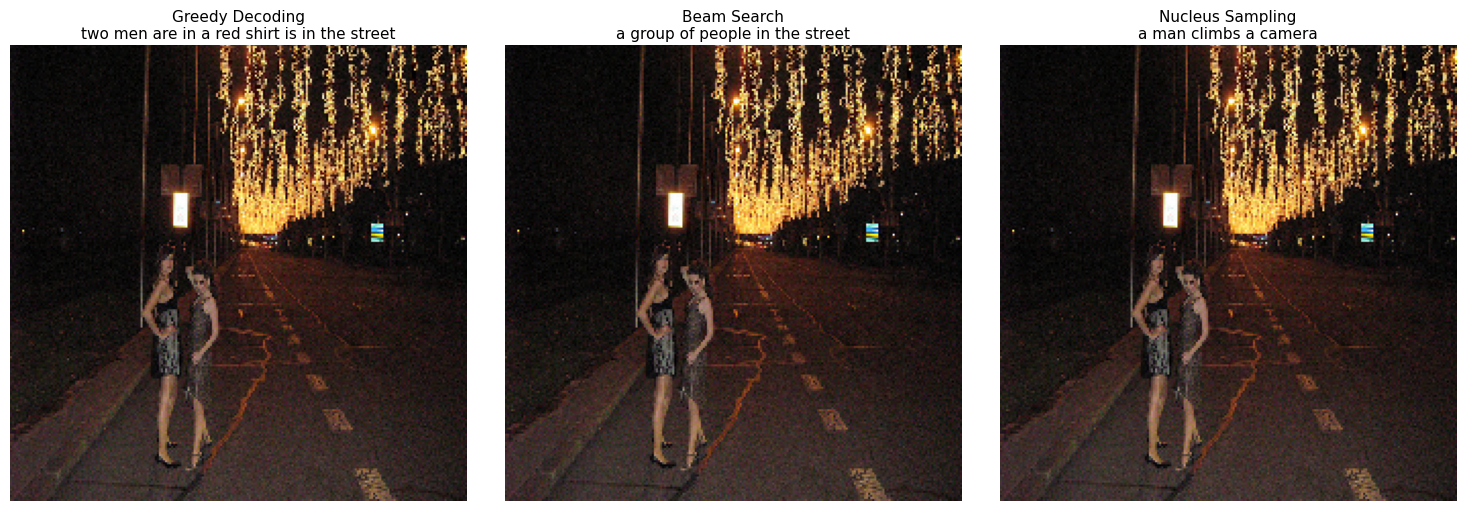


Method                         | Generated Caption
------------------------------ | --------------------------------------------------
Greedy Decoding                | two men are in a red shirt is in the street
Beam Search                    | a group of people in the street
Nucleus Sampling               | a man climbs a camera

Ground Truth Captions:
  1. startseq two ladies wearing dresses pose on the side of the road at night endseq
  2. startseq two woman wearing dresses stand in the street and pose endseq
  3. startseq two women in dresses pose on a street endseq




{'greedy': 'two men are in a red shirt is in the street',
 'beam_standard': 'a group of people in the street',
 'nucleus': 'a man climbs a camera'}

In [ ]:
# Compare methods
print("\nComparing All Methods:")
compare_all_methods(model, test_ids[48])

# **EVALUATION METRICS**

In [ ]:
from nltk.tokenize import word_tokenize

# ======================================================
# EVALUATION METRICS
# ======================================================

def compute_bleu(refs, hyps):

    smooth = SmoothingFunction().method7
    b1 = corpus_bleu(refs, hyps, weights=(1, 0, 0, 0), smoothing_function=smooth)
    b2 = corpus_bleu(refs, hyps, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    b3 = corpus_bleu(refs, hyps, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
    b4 = corpus_bleu(refs, hyps, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    return b1, b2, b3, b4

def compute_meteor(refs_list, hyps_list):

    scores = []
    for refs, hyp in zip(refs_list, hyps_list):
        # Convert hyp tokens to string
        if isinstance(hyp, str):
            hyp_str = hyp
        else:
            hyp_str = " ".join(hyp)

        # Convert ref tokens to strings
        ref_strs = []
        for r in refs:
            if isinstance(r, str):
                ref_strs.append(r)
            else:
                ref_strs.append(" ".join(r))

        # Tokenize hypothesis and references using word_tokenize
        hyp_tokens = word_tokenize(hyp_str.lower())
        ref_tokens_list = [word_tokenize(ref.lower()) for ref in ref_strs]

        # Compute METEOR score
        score = meteor_score(ref_tokens_list, hyp_tokens)
        scores.append(score)

    return np.mean(scores)

def compute_rouge(refs_list, hyps_list):

    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    scores = []
    for refs, hyp in zip(refs_list, hyps_list):
        hyp_str = " ".join(hyp) if not isinstance(hyp, str) else hyp
        per_ref_scores = []
        for r in refs:
            ref_str = " ".join(r) if not isinstance(r, str) else r
            s = scorer.score(ref_str, hyp_str)["rougeL"].fmeasure
            per_ref_scores.append(s)
        scores.append(max(per_ref_scores))
    return np.mean(scores)

def compute_cider(refs_dict, hyps_dict):
    cider_scorer = Cider()
    score, _ = cider_scorer.compute_score(refs_dict, hyps_dict)
    return score

In [ ]:
# ======================================================
# FULL EVALUATION FOR GREEDY
# ======================================================

def evaluate_greedy(model, ids_list, captions_dict, tokenizer, max_len):

    print(f"\n{'='*70}")
    print(f"🔍 Starting Evaluation - GREEDY DECODING")
    print(f"Images: {len(ids_list)}")
    print(f"{'='*70}\n")

    refs = []
    hyps = []
    refs_coco = {}
    hyps_coco = {}

    for i, img_id in enumerate(ids_list):
        if (i + 1) % 50 == 0:
            print(f"  Processing: {i+1}/{len(ids_list)}...")

        # Build image path
        img_path = safe_image_path(img_id)
        if not os.path.exists(img_path):
            continue

        # Generate caption
        try:
            pred = greedy_caption(
                model=model,
                img_path=img_path,
                tokenizer=tokenizer,
                max_len=max_len
            )
        except Exception as e:
            print(f"  ⚠️ Error on {img_id}: {e}")
            continue

        hyp_tokens = pred.split()
        if len(hyp_tokens) == 0:
            hyp_tokens = ["empty"]

        hyps.append(hyp_tokens)
        hyps_coco[img_id] = [" ".join(hyp_tokens)]

        # Ground truth
        if img_id not in captions_dict:
            continue

        gt_list = []
        for cap in captions_dict[img_id]:
            tokens = cap.split()
            # Remove startseq and endseq
            if tokens and tokens[0] == "startseq":
                tokens = tokens[1:]
            if tokens and tokens[-1] == "endseq":
                tokens = tokens[:-1]
            if tokens:
                gt_list.append(tokens)

        if gt_list:
            refs.append(gt_list)
            refs_coco[img_id] = [" ".join(t) for t in gt_list]

    print(f"\nGenerated {len(hyps)} captions\n")

    # Compute metrics
    print("Computing metrics...")
    bleu1, bleu2, bleu3, bleu4 = compute_bleu(refs, hyps)
    meteor = compute_meteor(refs, hyps)
    rougeL = compute_rouge(refs, hyps)
    cider = compute_cider(refs_coco, hyps_coco)

    results = {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "ROUGE-L": rougeL,
        "CIDEr": cider,
    }

    return results

In [ ]:
# ======================================================
# FULL EVALUATION FOR BEAM SEARCH
# ======================================================

def evaluate_beam(model, ids_list, captions_dict, tokenizer, max_len, beam_size=5):

    print(f"\n{'='*70}")
    print(f"🔍 Starting Evaluation - BEAM SEARCH")
    print(f"Images: {len(ids_list)}")
    print(f"Beam Size: {beam_size}")
    print(f"{'='*70}\n")

    refs = []
    hyps = []
    refs_coco = {}
    hyps_coco = {}

    for i, img_id in enumerate(ids_list):
        if (i + 1) % 50 == 0:
            print(f"  Processing: {i+1}/{len(ids_list)}...")

        # Build image path
        img_path = safe_image_path(img_id)
        if not os.path.exists(img_path):
            continue

        # Generate caption
        try:
            pred = beam_search_caption(
                model=model,
                img_path=img_path,
                tokenizer=tokenizer,
                max_len=max_len,
                beam_size=beam_size
            )
        except Exception as e:
            print(f"  ⚠️ Error on {img_id}: {e}")
            continue

        hyp_tokens = pred.split()
        if len(hyp_tokens) == 0:
            hyp_tokens = ["empty"]

        hyps.append(hyp_tokens)
        hyps_coco[img_id] = [" ".join(hyp_tokens)]

        # Ground truth
        if img_id not in captions_dict:
            continue

        gt_list = []
        for cap in captions_dict[img_id]:
            tokens = cap.split()
            # Remove startseq and endseq
            if tokens and tokens[0] == "startseq":
                tokens = tokens[1:]
            if tokens and tokens[-1] == "endseq":
                tokens = tokens[:-1]
            if tokens:
                gt_list.append(tokens)

        if gt_list:
            refs.append(gt_list)
            refs_coco[img_id] = [" ".join(t) for t in gt_list]

    print(f"\nGenerated {len(hyps)} captions\n")

    # Compute metrics
    print("Computing metrics...")
    bleu1, bleu2, bleu3, bleu4 = compute_bleu(refs, hyps)
    meteor = compute_meteor(refs, hyps)
    rougeL = compute_rouge(refs, hyps)
    cider = compute_cider(refs_coco, hyps_coco)

    results = {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "ROUGE-L": rougeL,
        "CIDEr": cider,
    }

    return results

In [ ]:
# ======================================================
# FULL EVALUATION FOR NUCLEUS SAMPLING
# ======================================================

def evaluate_nucleus(model, ids_list, captions_dict, tokenizer, max_len, p=0.9):

    print(f"\n{'='*70}")
    print(f"🔍 Starting Evaluation - NUCLEUS SAMPLING")
    print(f"Images: {len(ids_list)}")
    print(f"p-value: {p}")
    print(f"{'='*70}\n")

    refs = []
    hyps = []
    refs_coco = {}
    hyps_coco = {}

    for i, img_id in enumerate(ids_list):
        if (i + 1) % 50 == 0:
            print(f"  Processing: {i+1}/{len(ids_list)}...")

        # Build image path
        img_path = safe_image_path(img_id)
        if not os.path.exists(img_path):
            continue

        # Generate caption
        try:
            pred = nucleus_sampling_caption(
                model=model,
                img_path=img_path,
                tokenizer=tokenizer,
                max_len=max_len,
                p=p,
                temperature=0.8
            )
        except Exception as e:
            print(f"  ⚠️ Error on {img_id}: {e}")
            continue

        hyp_tokens = pred.split()
        if len(hyp_tokens) == 0:
            hyp_tokens = ["empty"]

        hyps.append(hyp_tokens)
        hyps_coco[img_id] = [" ".join(hyp_tokens)]

        # Ground truth
        if img_id not in captions_dict:
            continue

        gt_list = []
        for cap in captions_dict[img_id]:
            tokens = cap.split()
            # Remove startseq and endseq
            if tokens and tokens[0] == "startseq":
                tokens = tokens[1:]
            if tokens and tokens[-1] == "endseq":
                tokens = tokens[:-1]
            if tokens:
                gt_list.append(tokens)

        if gt_list:
            refs.append(gt_list)
            refs_coco[img_id] = [" ".join(t) for t in gt_list]

    print(f"\nGenerated {len(hyps)} captions\n")

    # Compute metrics
    print("Computing metrics...")
    bleu1, bleu2, bleu3, bleu4 = compute_bleu(refs, hyps)
    meteor = compute_meteor(refs, hyps)
    rougeL = compute_rouge(refs, hyps)
    cider = compute_cider(refs_coco, hyps_coco)

    results = {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "ROUGE-L": rougeL,
        "CIDEr": cider,
    }

    return results

In [ ]:
# ======================================================
# COMPARE ALL 3 METHODS
# ======================================================

def evaluate_all_methods(model, ids_list, captions_dict, tokenizer, max_len):

    print(f"\n{'='*80}")
    print(f"🎯 EVALUATING ALL 3 METHODS")
    print(f"Total Images: {len(ids_list)}")
    print(f"{'='*80}\n")

    # 1. Greedy
    results_greedy = evaluate_greedy(model, ids_list, captions_dict, tokenizer, max_len)

    # 2. Beam Search
    results_beam = evaluate_beam(model, ids_list, captions_dict, tokenizer, max_len, beam_size=5)

    # 3. Nucleus Sampling
    results_nucleus = evaluate_nucleus(model, ids_list, captions_dict, tokenizer, max_len, p=0.9)

    # Display comparison table
    print(f"\n{'='*80}")
    print(f"📊 RESULTS COMPARISON")
    print(f"{'='*80}\n")

    print(f"{'Metric':<15s} | {'Greedy':<12s} | {'Beam Search':<12s} | {'Nucleus':<12s}")
    print(f"{'-'*15} | {'-'*12} | {'-'*12} | {'-'*12}")

    metrics = ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR", "ROUGE-L", "CIDEr"]
    for metric in metrics:
        print(f"{metric:<15s} | {results_greedy[metric]:<12.4f} | {results_beam[metric]:<12.4f} | {results_nucleus[metric]:<12.4f}")

    print(f"\n{'='*80}\n")

    return {
        'greedy': results_greedy,
        'beam': results_beam,
        'nucleus': results_nucleus
    }

In [ ]:
# # Evaluate single method
# results_greedy = evaluate_greedy(model, test_ids[:100], clean_captions, tokenizer, max_len)
# print(results_greedy)

# results_beam = evaluate_beam(model, test_ids[:100], clean_captions, tokenizer, max_len, beam_size=5)
# print(results_beam)

# results_nucleus = evaluate_nucleus(model, test_ids[:100], clean_captions, tokenizer, max_len, p=0.9)
# print(results_nucleus)

# Or evaluate all 3 methods at once
all_results = evaluate_all_methods(model, test_ids[:300], clean_captions, tokenizer, max_len)


🎯 EVALUATING ALL 3 METHODS
Total Images: 300


🔍 Starting Evaluation - GREEDY DECODING
Images: 300

  Processing: 50/300...
  Processing: 100/300...
  Processing: 150/300...
  Processing: 200/300...
  Processing: 250/300...
  Processing: 300/300...

Generated 300 captions

Computing metrics...

🔍 Starting Evaluation - BEAM SEARCH
Images: 300
Beam Size: 5

  Processing: 50/300...
  Processing: 100/300...
  Processing: 150/300...
  Processing: 200/300...
  Processing: 250/300...
  Processing: 300/300...

Generated 300 captions

Computing metrics...

🔍 Starting Evaluation - NUCLEUS SAMPLING
Images: 300
p-value: 0.9

  Processing: 50/300...
  Processing: 100/300...
  Processing: 150/300...
  Processing: 200/300...
  Processing: 250/300...
  Processing: 300/300...

Generated 300 captions

Computing metrics...

📊 RESULTS COMPARISON

Metric          | Greedy       | Beam Search  | Nucleus     
--------------- | ------------ | ------------ | ------------
BLEU-1          | 0.7104       | 0.795